<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/student/W1D1_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D1_Generalization/student/W1D1_Tutorial2.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 2: Generalization in Neuroscience

**Week 1, Day 1: Generalization**

**By Neuromatch Academy**

__Content creators:__ Samuele Bolotta, Patrick Mineault and Shreya Saxena

__Content reviewers:__ Samuele Bolotta, Lily Chamakura, RyeongKyung Yoon, Yizhou Chen, Ruiyi Zhang, Aakash Agrawal, Alish Dipani, Hossein Rezaei, Yousef Ghanbari, Mostafa Abdollahi

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk



___


# Tutorial Objectives

*Estimated timing of tutorial: 75 minutes*

This tutorial will introduce you to generalization in neuroscience. We'll look at a classic neuroscience paper, [Sussillo et al. (2015)](https://www.nature.com/articles/nn.4042), that compares how artificial and biological neural networks solve different motor tasks. This paper looks at how linear arm movements are generated in motor cortex; later extensions of these ideas (e.g. [Codol et al. 2024](https://elifesciences.org/reviewed-preprints/88591v2); [Almani et al. 2024](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=x-YACVoAAAAJ&sortby=pubdate&citation_for_view=x-YACVoAAAAJ:1yQoGdGgb4wC)) address how more complex skilled movements, including handwriting, can be generated, continuing our theme for today's tutorials. We'll look at a popular AI-derived framework for understanding how the brain solves tasks: task-driven neural networks.

Our learning goals for this tutorial are as follows:

1. Understand core goals in neuroscience. Examine the fundamental questions that drive neuroscience research, such as the 'What', 'How', and 'Why' behind neurological functions and behaviors.

2. Conceptualize generalization in neuroscience. Gain insights into what generalization entails within the field of neuroscience, understanding how principles of neural generalization can inform and be informed by artificial intelligence.

3. Evaluate the impact of architectural choices. Discuss how different architectural decisions and the selection of priors in model design can introduce inductive biases, affecting the generalization capabilities of both neural and artificial systems.

4. Illustrate robustness in noisy environments. Identify and describe real-world instances where the pursuit of robustness against noise has led to converging strategies in both neuroscience and artificial intelligence.

In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "x4pa5"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

Output()

---
# Setup



##  Install and import feedback gadget

In [2]:
# @title Install and import feedback gadget

!pip install numpy scipy matplotlib torch tqdm vibecheck --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt - leave this as is
        notebook_section,
        {
        "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
        "name": "sciencematch_sm", # change the name of the course : neuromatch_dl, climatematch_ct, etc
        "user_key": "y1x3mpx5",
        },
    ).render()

feedback_prefix = "W1D1_T2"

In [3]:
# @title Import dependencies
# @markdown

# Standard Libraries for file and operating system operations, security, and web requests
import os
import hashlib
import requests
import random
import gc

# Core Python data science and visualization libraries
import numpy as np
import scipy
from matplotlib import pyplot as plt
import logging
from IPython.display import IFrame, display, Image

# Deep Learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.autograd import profiler

# Additional utilities
from tqdm.autonotebook import tqdm

/var/folders/58/fbqcqt111lgc_cx0vvpykbzc0000gp/T/ipykernel_99078/2496908858.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


##  Figure Settings

In [4]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perform high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

## Plotting Functions

In [5]:
# @title Plotting functions
# @markdown

xlim = (-1.8, .7)

def plot_inputs_over_time(timesteps, avg_inputs, title='Inputs over Time'):
    """
    Plot the inputs over time.

    Inputs:
    - timesteps (list or array-like): A sequence of time steps at which the inputs were recorded.
      This acts as the x-axis in the plot, representing the progression of time.
    - avg_inputs (list or array-like): The average values of inputs corresponding to each time step.
      These values are plotted on the y-axis, showing the magnitude of inputs over time.
    - title (string): The title of the plot

    Returns:
    This function generates and displays a plot using Matplotlib.
    """
    plt.figure(figsize=(8, 3))
    num_features = avg_inputs.shape[1] if hasattr(avg_inputs, 'shape') else len(avg_inputs[0])

    for feature_idx in range(num_features):
        current_feature_values = avg_inputs[:, feature_idx] if hasattr(avg_inputs, 'shape') else [row[feature_idx] for row in avg_inputs]
        label = f'Feature {feature_idx + 1}' if feature_idx < num_features - 1 else 'Go Cue'
        plt.plot(timesteps, current_feature_values, label=label)

    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Value (A.U.)')
    plt.subplots_adjust(right=0.7)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.tight_layout()
    plt.xlim(min(timesteps), max(timesteps))
    plt.show()

def plot_muscles_over_time(timesteps, avg_output, title='Muscles over Time'):
    """
    Plot the average outputs over time for two muscles to visualize changes in output values.
    The avg_output is expected to be a 250x2 array where each column corresponds to a different muscle.

    Inputs:
    - timesteps (list or array-like): A sequence of time steps at which the outputs were recorded.
      This acts as the x-axis in the plot, representing the progression of time.
    - avg_output (array-like, shape [250, 2]): The average values of outputs, with each column
      representing the output over time for each muscle.
    - title (string): The title of the plot

    Returns:
    This function generates and displays a plot using Matplotlib.
    """

    plt.figure(figsize=(8, 3))  # Set the figure size
    plt.plot(timesteps, avg_output[:, 0], label='Muscle 1')  # Plot for muscle 1
    plt.plot(timesteps, avg_output[:, 1], label='Muscle 2')  # Plot for muscle 2
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Value (A.U.)')

    # Adjust plot margins to provide space for the legend outside the plot
    plt.subplots_adjust(right=0.7)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)  # Placing legend outside

    plt.tight_layout()
    plt.xlim(min(timesteps), max(timesteps))  # Ensuring x-axis covers the range of timesteps
    plt.show()

def plot_training_validation_losses(epoch_losses, val_losses, actual_num_epochs, title):

    """
    This function plots the training and validation losses over epochs.

    Inputs:
    - epoch_losses (list of float): List containing the training loss for each epoch. Each element is a float
      representing the loss calculated after each epoch of training.
    - val_losses (list of float): List containing the validation loss for each epoch. Similar to `epoch_losses`, but
      for the validation set, allowing for the comparison between training and validation performance.
    - actual_num_epochs (int): The actual number of epochs the training went through. This could be different from
      the initially set number of epochs if early stopping was employed. It determines the range of the x-axis
      in the plot.
    - title (str): A string that sets the title of the plot. This allows for customization of the plot for better
      readability and interpretation.

    Outputs:
    This function generates and displays a plot using matplotlib.
    """

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, actual_num_epochs + 1), epoch_losses, label='Training Loss')
    plt.plot(range(1, actual_num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.xlim(xlim)
    plt.show()

# Plot hidden units in UnregularizedRNN
def plot_hidden_unit_activations(hidden_states, times, neurons_to_plot=5, title='PSTHs of Hidden Units'):
    """
    This function plots the average activation of a specified number of neurons from the hidden layers
    of a neural network over a certain number of timesteps.

    Inputs:
        hidden_states (tensor): A 2D tensor containing the hidden states of a network. The dimensions
                                should be (time, features), where 'time' represents the sequence of
                                timesteps, 'batch' represents different data samples, and 'features' represents
                                the neuron activations or features at each timestep.
        times (tensor): The time range that we focus on.
        neurons_to_plot (int, optional): The number of neuron activations to plot, starting from the first neuron.
                                         Defaults to 5.
        title (str, optional): The title of the plot, allowing customization for specific analyses or presentations.
                               Defaults to 'PSTHs of Hidden Units'.

    This function generates and displays a plot of the average activation of specified
    neurons over the selected timesteps, providing a visual analysis of neuron behavior within the network.
    """
    # Apply the nonlinearity to each hidden state before averaging
    rectified_tanh = lambda x: np.where(x > 0, np.tanh(x), 0)
    hidden_states_rectified = rectified_tanh(np.array(hidden_states))

    # Plotting
    plt.figure(figsize=(8, 4))
    for i in range(min(neurons_to_plot, hidden_states_rectified.shape[1])):
        plt.plot(times, hidden_states_rectified[:, i], label=f'Neuron {i+1}')

    plt.xlabel('Time Steps')
    plt.ylabel('Activation')
    plt.title(title)

    # Adjust plot margins to provide space for the legend outside the plot
    plt.subplots_adjust(right=0.8)  # Adjust this value to create more or less space on the right
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')  # Placing legend outside

    plt.xlim(times[0], times[-1])  # Setting x-axis limits based on the provided time tensor
    plt.show()

def plot_psth(data, condition=0, neurons_to_plot=5, title='PSTHs of real data'):
    """
    This function plots PSTHs from real neural data

    Args:
        data (dict): The data from the mat file from Sussillo et al. (2015)
        condition (int, optional): The condition (from 0 to 26). Defaults to 0.
        neurons_to_plot (int, optional): The number of neuron activations to plot, starting from the first neuron.
                                         Defaults to 5.
        title (str, optional): The title for the PSTH plot. This allows users to specify the context or the
                     experiment from which the data is derived.

    Outputs:
    This function directly generates and displays a plot using matplotlib
    to visually represent the neural activity across time bins.
    """
    # Plot
    plt.figure(figsize=(8, 4))
    for neuron_idx in range(neurons_to_plot):  # Iterate over each feature/channel
        times_real = data['comboNjs'][0, neuron_idx]['interpTimes'][0]['times'][0].squeeze().astype(float)
        t0 = float(data['comboNjs'][0, neuron_idx]['interpTimes'][0]['moveStarts'][0].item())
        times_real = (times_real - t0) / 1000.0

        spikes_real = data['comboNjs'][0, neuron_idx]['cond'][0]['interpPSTH'][0].squeeze()
        plt.plot(times_real, spikes_real, label=f'Neuron {neuron_idx+1}')

    plt.xlabel('Time (s)')
    plt.ylabel('Average Activity (Hz)')
    plt.title(title)

    # Adjust plot margins and place legend outside the plot
    plt.subplots_adjust(right=0.8)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

    plt.xlim(times_real[0], times_real[-1])  # Assume times_real is defined
    plt.show()


def plot_perturbation_results(perturbation_strengths, results_regularized, results_unregularized, title):
    """
    This function plots the normalized error percentages of two models (regularized and unregularized) under various
    perturbation strengths.

    Inputs:
        perturbation_strengths (list of float): A list of perturbation strengths tested, representing the
                                                 magnitude of perturbations applied to the model input or parameters.
        results_regularized (list of tuples): Each tuple contains (mean error, standard deviation) for the regularized model
                                         at each perturbation strength.
        results_unregularized (list of tuples): Each tuple contains (mean error, standard deviation) for the unregularized model
                                          at each perturbation strength.
        title (str): The title of the plot, allowing for customization to reflect the analysis context.

    The function generates and displays a bar plot comparing the normalized error
    rates of regularized and unregularized models under different perturbation strengths, with error bars representing the
    standard deviation of errors, normalized to percentage scale.
    """
    mean_errors_regularized, std_errors_regularized = zip(*results_regularized)
    mean_errors_unregularized, std_errors_unregularized = zip(*results_unregularized)

    print("mean_errors_regularized", mean_errors_regularized)
    print("mean_errors_unregularized", mean_errors_unregularized)

    # Plotting
    plt.figure(figsize=(8, 6))
    bar_width = 0.35
    bar_positions = np.arange(len(perturbation_strengths))

    plt.bar(bar_positions - bar_width/2, mean_errors_regularized, width=bar_width, color='blue', yerr=std_errors_regularized, capsize=5, label='Regularized Model')
    plt.bar(bar_positions + bar_width/2, mean_errors_unregularized, width=bar_width, color='red', yerr=std_errors_unregularized, capsize=5, label='Unregularized Model')

    plt.xlabel('Perturbation Magnitude')
    plt.ylabel('Normalized Error (%)')
    plt.title(title)
    plt.xticks(bar_positions, [f"{x:.5f}" if x < 0.1 else f"{x}" for x in perturbation_strengths])
    plt.legend()
    plt.ylim(0, 100)
    plt.show()

## Set device

In [6]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.
# @markdown

# inform the user if the notebook uses GPU or CPU.

def set_device():
    """
    Determines and sets the computational device for PyTorch operations based on the availability of a CUDA-capable GPU.

    Outputs:
    - device (str): The device that PyTorch will use for computations ('cuda' or 'cpu'). This string can be directly used
    in PyTorch operations to specify the device.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this notebook. \n"
              "If you want to enable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    else:
        print("GPU is enabled in this notebook. \n"
              "If you want to disable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `None` from the dropdown menu")

    return device

device = set_device()

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [7]:
# @title Set random seed, when using `pytorch`

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

## Data Retrieval

In [8]:
import os
import requests
import hashlib

def retrieve_file(fname, url, expected_md5):
    # Check if the file already exists
    if not os.path.isfile(fname):
        try:
            # Attempt to download the file
            response = requests.get(url)
        except requests.ConnectionError:
            # Handle connection errors during the download
            print("!!! Failed to download data !!!")
        else:
            # No connection errors, proceed to check the response
            if response.status_code != requests.codes.ok:
                # Check if the HTTP response status code indicates a successful download
                print("!!! Failed to download data !!!")
            elif hashlib.md5(response.content).hexdigest() != expected_md5:
                # Verify the integrity of the downloaded file using MD5 checksum
                print("!!! Data download appears corrupted !!!")
            else:
                # If download is successful and data is not corrupted, save the file
                with open(fname, "wb") as fid:
                    fid.write(response.content) # Write the downloaded content to a file

# List of files to be downloaded with their respective URLs and expected MD5 hashes
files = [
    ("regularized_model_final.pth", "https://osf.io/kc7sb/download", "9435a9c2ea75766144bf840b25bfb97e"),
    ("unregularized_model_final.pth", "https://osf.io/9vsy5/download", "2e3dc9551b677206e2315788df354a91"),
    ("condsForSimJ2moMuscles.mat", "https://osf.io/wak7e/download", "257d16c4d92759d615bf5cac75dd9a1f"),
    ("m1_reaching_data.mat", "https://osf.io/p2x4n/download", "6fc65443b9632db47772dd2efaadeee0")
]

for fname, url, expected_md5 in files:
    retrieve_file(fname, url, expected_md5)

## Helper Functions

In [9]:
#@title Helper functions
# @markdown

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0)

def grad_rectified_tanh(x):
    return torch.where(x > 0, 1 - torch.tanh(x)**2, 0)

def grad_tanh(x):
    return 1 - torch.tanh(x)**2

def compute_l2_regularization(parameters, alpha):
    l2_reg = sum(p.pow(2.0).sum() for p in parameters)
    return alpha * l2_reg

def prepare_dataset(file_path, feature_idx=7, muscle_idx=1):
    """
    Load and preprocess data from a .mat file for RNN training.

    Args:
    - file_path: str, path to the .mat file containing the dataset.
    - feature_idx: int, index for individual features for plotting. Max 14.
    - muscle_idx: int, index for muscles for plotting. Max 1.

    Returns:
    - normalised_inputs: Tensor, normalized and concatenated Plan and Go Envelope tensors.
    - avg_output: Tensor, average muscle activity across conditions and delays.
    - timesteps: np.ndarray, array of time steps for plotting.
    """
    # Load the .mat file
    data = scipy.io.loadmat(file_path)

    # Extract condsForSim struct
    conds_for_sim = data['condsForSim']

    # Initialize lists to store data for all conditions
    go_envelope_all, plan_all, muscle_all = [], [], []

    # Get the number of conditions (rows) and delay durations (columns)
    num_conditions, num_delays = conds_for_sim.shape

    times = conds_for_sim['timesREmove'][0][0] / 1000.0

    # Select the same time period as the PSTHs
    rg = slice(46, 296)

    for i in range(num_conditions):  # Loop through each condition
        go_envelope_condition, plan_condition, muscle_condition = [], [], []

        for j in range(num_delays):  # Loop through each delay duration
            condition = conds_for_sim[i, j]
            go_envelope, plan, muscle = condition['goEnvelope'], condition['plan'], condition['muscle']
            selected_muscle_data = muscle[:, [3, 4]]  # Select only specific muscles
            go_envelope_condition.append(go_envelope[rg, :])
            plan_condition.append(plan[rg, :])
            muscle_condition.append(selected_muscle_data[rg, :])

        # Convert lists of arrays to tensors and append to all conditions
        go_envelope_all.append(torch.tensor(np.array(go_envelope_condition), dtype=torch.float32))
        plan_all.append(torch.tensor(np.array(plan_condition), dtype=torch.float32))
        muscle_all.append(torch.tensor(np.array(muscle_condition), dtype=torch.float32))

    times = times[rg]

    # Stack tensors for all conditions
    go_envelope_tensor, plan_tensor, output = torch.stack(go_envelope_all), torch.stack(plan_all), torch.stack(muscle_all)

    # Cleanup to free memory
    del data, conds_for_sim, go_envelope_all, plan_all, muscle_all
    gc.collect()

    # Normalize and Standardize Plan Tensor
    plan_tensor = normalize_and_standardize(plan_tensor)

    # Normalise and concatenate Plan and Go Envelope Tensors
    normalised_inputs = normalize_and_standardize(torch.cat([plan_tensor, go_envelope_tensor], dim=3))

    fixed_delay = 3
    inputs_no_delay = normalised_inputs[:, fixed_delay, ...]
    output_no_delay = output[:, fixed_delay, ...]
    return inputs_no_delay, normalised_inputs, output_no_delay, output, times

def normalize_and_standardize(tensor):
    """
    Normalize and standardize a given tensor.

    Args:
    - tensor: Tensor, the tensor to be normalized and standardized.

    Returns:
    - standardized_normalized_tensor: Tensor, the normalized and standardized tensor.
    """
    min_val, max_val = tensor.min(), tensor.max()
    tensor = (tensor - min_val) / (max_val - min_val)  # Normalize
    mean, std = tensor.mean(), tensor.std()
    return (tensor - mean) / std  # Standardize

def train_val_split():
    """Split the data into train and validation splits.
    """
    train_split, val_split = random_split(range(27), [20, 7])
    return sorted(list(train_split)), sorted(list(val_split))

# Section 1: Motivation: How the brain generates motor commands

Let's put ourselves in the mindset of a neuroscientist trying to understand how the brain generates motor sequences. A classic example of a complex motor sequence is handwriting, which involves coordinated movement of the arm, wrist and fingers during handwriting. 

The mapping between the goal (e.g. moving the arm) and the sequence of motor commands that drive different muscles is highly nonlinear and recurrent. Furthermore, the brain must *generalize* beyond its training data; for instance, when the recurrent connections of the brain change due to noise or homeostasis, or when the arm is under load. How does the brain do that?

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/static/setup.png?raw=true" width=600 />

*Image adapted from Rizzoglio et al. (2023). From monkeys to humans: observation-based EMG brain–computer interface decoders for humans with paralysis. Journal of Neural Engineering. 10.1088/1741-2552/ad038e. CC-BY 4.0.*

Our neuroscientist is trying to address a *how* question: how does the brain find solutions to complex control problems that generalize? Recurrent neural networks (RNNs), a type of artificial neural network, have proven a very useful tool to address these *how* questions. They mimic the adaptability and plasticity observed in biological neural networks through interconnected artificial neurons, weights dictating connection strengths, and activation functions triggering neuron responses. **Task-driven neural networks** are trained *in silico* to solve similar tasks to ones that the brain must solve. Properly constrained, they often find solutions to problems that are similar to the ones that the brain seems to find. The trained artificial neural networks can then be used to investigate, mechanistically, how a task is solved. 

![Picture which shows an RNN.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D1_Generalization/static/rnn.png?raw=true)

Let's illustrate these ideas with a classic paper in this field: [Sussillo et al. (2015)](https://www.nature.com/articles/nn.4042). They train an RNN to solve a motor task by learning to map commands to arm movements recorded via electromyography (EMG). Looking inside this RNN gives them a platform to investigate questions about generalization. They then compare the data from the RNN to spike data from motor cortex (M1) of a monkey performing a similar task. Do they perform similarly? Is the RNN performing the same kind of task as the brain, in a similar way?

# Section 2: Training an unregularized task-driven neural network

In this activity, our goal is to train recurrent neural networks to mimic the muscle activity of monkeys during arm movements. The challenge is to transform simple inputs into complex patterns of muscle activity over time and space.

In [10]:
# Define the path to the dataset file containing conditions for simulation of muscles
file_path = 'condsForSimJ2moMuscles.mat'

# Prepare the dataset by loading and processing it from the specified file path
normalised_inputs, normalised_inputs_with_delay, outputs, outputs_with_delay, times = prepare_dataset(file_path)

print("Shape of the inputs", normalised_inputs.shape)
print("Shape of the output", outputs.shape)

Shape of the inputs torch.Size([27, 250, 16])
Shape of the output torch.Size([27, 250, 2])


These dimensions correspond to the following:

* 27 conditions, one for each reach
* 250 time steps at a 100Hz sampling rate (2.5s trials)
* For inputs, there are 16 features including the go cue.
* For outputs, there are 2 features corresponding to the target electromyography (EMG) data for two muscles.

Now, let's visualize the data.

Shape of the inputs torch.Size([250, 16])


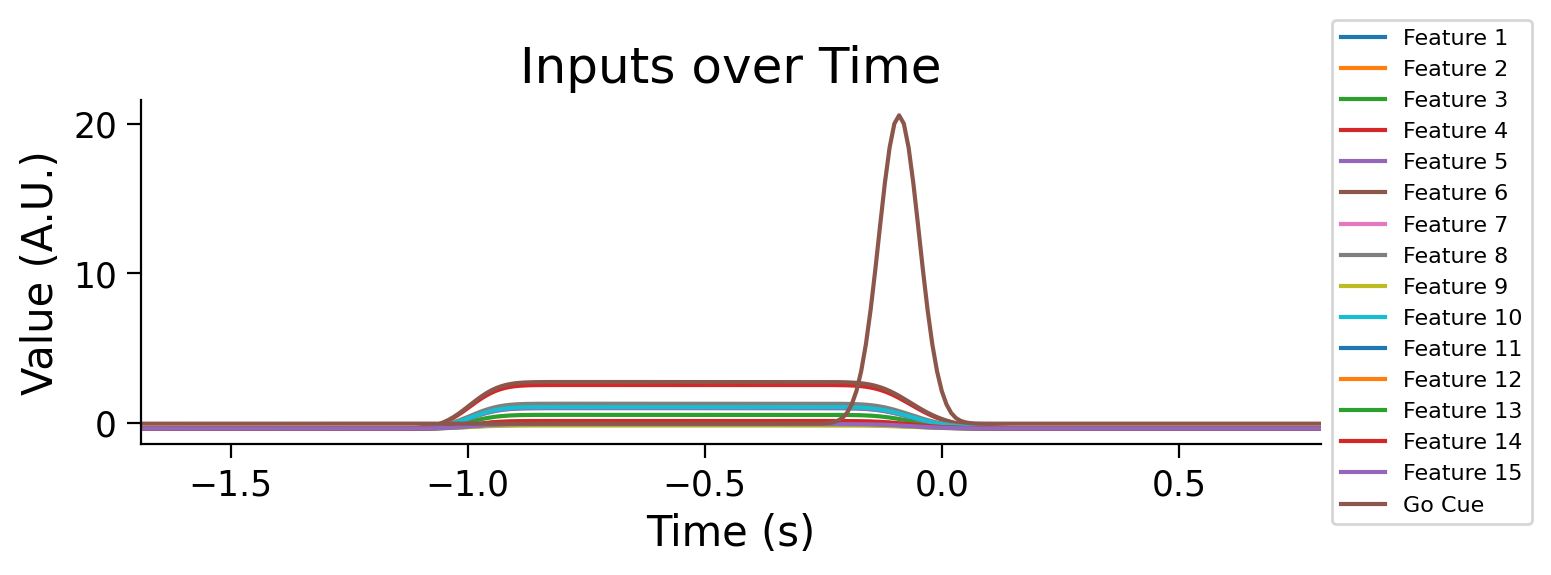

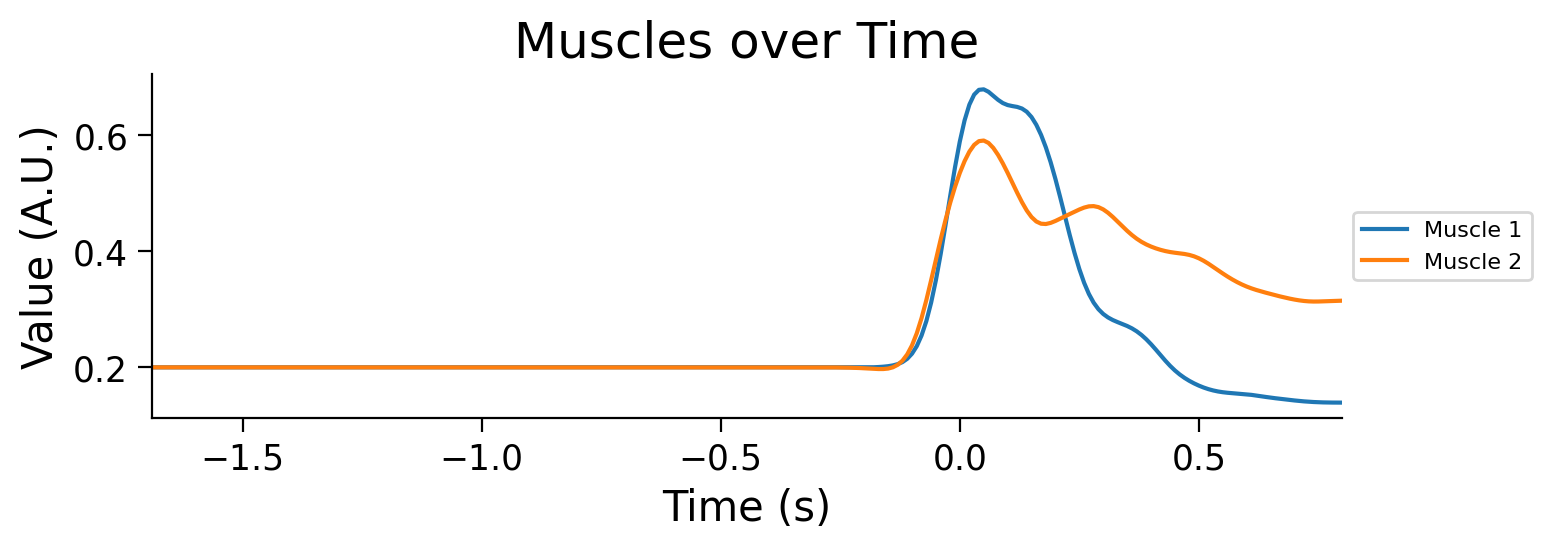

In [40]:
# Averaging across conditions and delays
avg_inputs = normalised_inputs.mean(dim=[0]).squeeze()
avg_outputs = outputs.mean(dim=[0])

avg_inputs[:, -1] *= 20

print("Shape of the inputs", avg_inputs.shape)
#Plot inputs and outputs
plot_inputs_over_time(times, avg_inputs)
plot_muscles_over_time(times, avg_outputs)

As you can see, the movement to be generated is encoded by a 16-dimensional signal during the hold period (from -1 to 0s). The go cue (feature 16, time 0) signals that it's time to generate the movement. The movements of the muscles are generated right after the GO cue.

Let's create a PyTorch dataset to wrap this raw tensor.

In [12]:
class TimeseriesDataset(Dataset):
    def __init__(self, inputs, targets):
        """
        inputs: Tensor of shape [#examples, time, input_features]
        targets: Tensor of shape [#examples, time, output_features]
        """
        self.inputs = inputs
        self.targets = targets
        self.num_conditions = inputs.shape[0]
        assert inputs.shape[0] == targets.shape[0]

    def __len__(self):
        return self.num_conditions

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        target_seq = self.targets[idx]
        return input_seq, target_seq

# Create the dataset with the fixed delay
train_idx, val_idx = train_val_split()
train_dataset = TimeseriesDataset(normalised_inputs[train_idx], outputs[train_idx])
val_dataset = TimeseriesDataset(normalised_inputs[val_idx], outputs[val_idx])

# Create DataLoaders
batch_size = 20
unregularized_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
unregularized_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Coding exercise 2.1: Defining an unregularized RNN

Let's start by defining an unregularized RNN `nn.Module` which takes in the time-varying control inputs and outputs muscle outputs.

The model is a single-layer recurrent neural network defined in continuous time. The network takes in an input vector and outputs muscle EMG. The hidden state of the network $\mathbf{x}$ evolves according to the equation:

$$\tau \frac{d\mathbf{x}}{dt} = -\mathbf{x} + \mathbf{B}\mathbf{u} + \mathbf{J}\mathbf{r} + \mathbf{b}$$

Here we have:

* $\mathbf{B}\mathbf{u}$ is the feedforward drive of the neural network, the inputs $\mathbf{u}$ are linearly projected through a set of weights $\mathbf{B}$
* $\mathbf{J}\mathbf{r}$ is the recurrent drive of the neural network, the recurrent activity $\mathbf{r}$ are linearly projected through a set of weights $\mathbf{J}$
* $\mathbf{r} = |\tanh(\mathbf{x})|$ is the hidden activity passed through a rectifying, saturating nonlinearity
* $\mathbf{b}$ is a constant
* $\tau$ is a scalar corresponding to the time-scale of the network, 50 ms

To transform this to a standard discrete-time neural network, we use Euler integration, with a time step equal to the resolution of the simulation, 10ms. See the [Comp Neuro W2D2](https://compneuro.neuromatch.io/tutorials/W2D2_LinearSystems/student/W2D2_Tutorial1.html?highlight=euler+integration#coding-exercise-1-forward-euler-integration) to brush up on this idea.

Thus, the discretized update equation will be:

$$\mathbf{x_{t+1}} = \mathbf{x}_{t} + \Delta t\frac{d\mathbf{x_t}}{dt}$$

There are a few more parameters to consider:

* The scale of the parameters of the input mixing matrix $\mathbf{B}$ is determined by $h$
* The scale of the parameters of the input mixing matrix $\mathbf{J}$ is determined by $g$. We initialize $g$ to a value larger than 1, so the neural network is in a chaotic regime.
* The network start with a hidden state $\mathbf{x}=0$

Finally, the observed EMG activity is given by a linear readout:

$$z = \mathbf{W}\mathbf{r} + c$$

Let's code up this unregularized neural network.

In [13]:
class UnregularizedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau_over_dt=5):
        super(UnregularizedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau_over_dt = tau_over_dt
        self.output_linear = nn.Linear(hidden_size, output_size)

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float))))
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh

    def forward(self, input, hidden):
        #################################################
        # TODO for students: fill in the missing variables
        # Fill out function and remove
        raise NotImplementedError("Student exercise: fill in the missing variables")
        #################################################

        # Calculate the visible firing rate from the hidden state.
        firing_rate_before = ...

        # Update hidden state
        recurrent_drive = torch.matmul(self.J, firing_rate_before.transpose(0, 1))
        input_drive = torch.matmul(self.B, input.transpose(0, 1))
        total_drive = recurrent_drive + input_drive + self.bx.unsqueeze(1)
        total_drive = total_drive.transpose(0, 1)

        # Euler integration for continuous-time update
        hidden = hidden + (1 / self.tau_over_dt) * (-hidden + total_drive)

        # Calculate the new firing rate given the update.
        firing_rate = ...

        # Project the firing rate linearly to form the output
        output = ...

        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [14]:
# to_remove solution
class UnregularizedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau_over_dt=5):
        super(UnregularizedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau_over_dt = tau_over_dt
        self.output_linear = nn.Linear(hidden_size, output_size)

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float))))
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh

    def forward(self, input, hidden):

        # Calculate the visible firing rate from the hidden state.
        firing_rate_before = self.nonlinearity(hidden)

        # Update hidden state
        recurrent_drive = torch.matmul(self.J, firing_rate_before.transpose(0, 1))
        input_drive = torch.matmul(self.B, input.transpose(0, 1))
        total_drive = recurrent_drive + input_drive + self.bx.unsqueeze(1)
        total_drive = total_drive.transpose(0, 1)

        # Euler integration for continuous-time update
        hidden = hidden + (1 / self.tau_over_dt) * (-hidden + total_drive)

        # Calculate the new firing rate given the update.
        firing_rate = self.nonlinearity(hidden)

        # Project the firing rate linearly to form the output
        output = self.output_linear(firing_rate)

        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [15]:
input_size = 16
hidden_size = 10
output_size = 2
g = 4
h_val = 1.0

model = UnregularizedRNN(input_size, hidden_size, output_size, g, h_val)
model.to(device)

for inputs, targets in unregularized_train_loader:
    hidden = model.init_hidden(batch_size)
    output, hidden_after = model(inputs[:, 0, :].to(device), hidden.to(device))
    assert output.shape == targets[:, 0].shape
    assert hidden_after.shape == hidden.shape
    break

Great! Now we have the model ready to go.

## Coding exercise 2.2: Evaluate function

We'll need a function that can generate an entire trajectory based on a set of inputs. To do that, we'll first initialize the hidden state of the model, then recurrently feed the inputs and the hidden states back into the model. Fill in the missing lines to generate an entire trajectory.

In [16]:
def generate_trajectory(model, inputs, device):
    #################################################
    # TODO for students: fill in the missing variables
    # Fill out function and remove
    raise NotImplementedError("Student exercise: fill in the missing variables")
    #################################################
    inputs = inputs.to(device)
    batch_size = inputs.size(0)
    h = ...

    loss = 0
    outputs = []
    hidden_states = []
    with torch.no_grad():
        for t in range(inputs.shape[1]):
            # Forward the model's input and hidden state to obtain the model
            # output and hidden state *h*.
            # Note that you should index the input tensor by the time dimension
            # Capture any additional outputs in 'rest'
            output, h, *rest = ...
            outputs.append(output)
            hidden_states.append(h.detach().clone())

    return torch.stack(outputs, axis=1).to(device), torch.stack(hidden_states, axis=1).to(device)

In [17]:
#to_remove solution
def generate_trajectory(model, inputs, device):
    inputs = inputs.to(device)
    batch_size = inputs.size(0)
    h = model.init_hidden(batch_size).to(device)

    loss = 0
    outputs = []
    hidden_states = []
    with torch.no_grad():
        for t in range(inputs.shape[1]):
            # Forward the model's input and hidden state to obtain the model
            # output and hidden state *h*.
            # Note that you should index the input tensor by the time dimension
            # Capture any additional outputs in 'rest'
            output, h, *rest = model(inputs[:, t], h)
            outputs.append(output)
            hidden_states.append(h.detach().clone())

    return torch.stack(outputs, axis=1).to(device), torch.stack(hidden_states, axis=1).to(device)

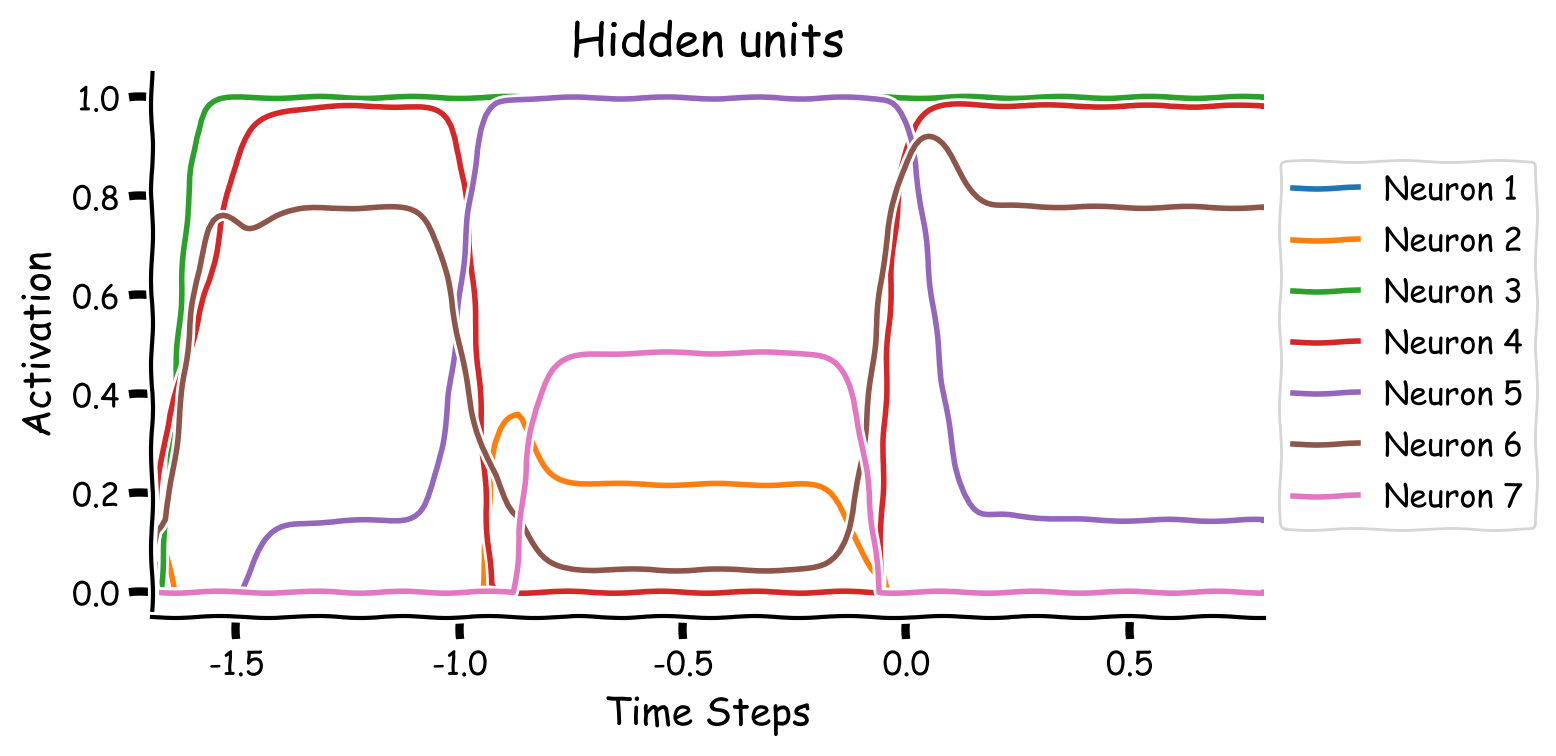

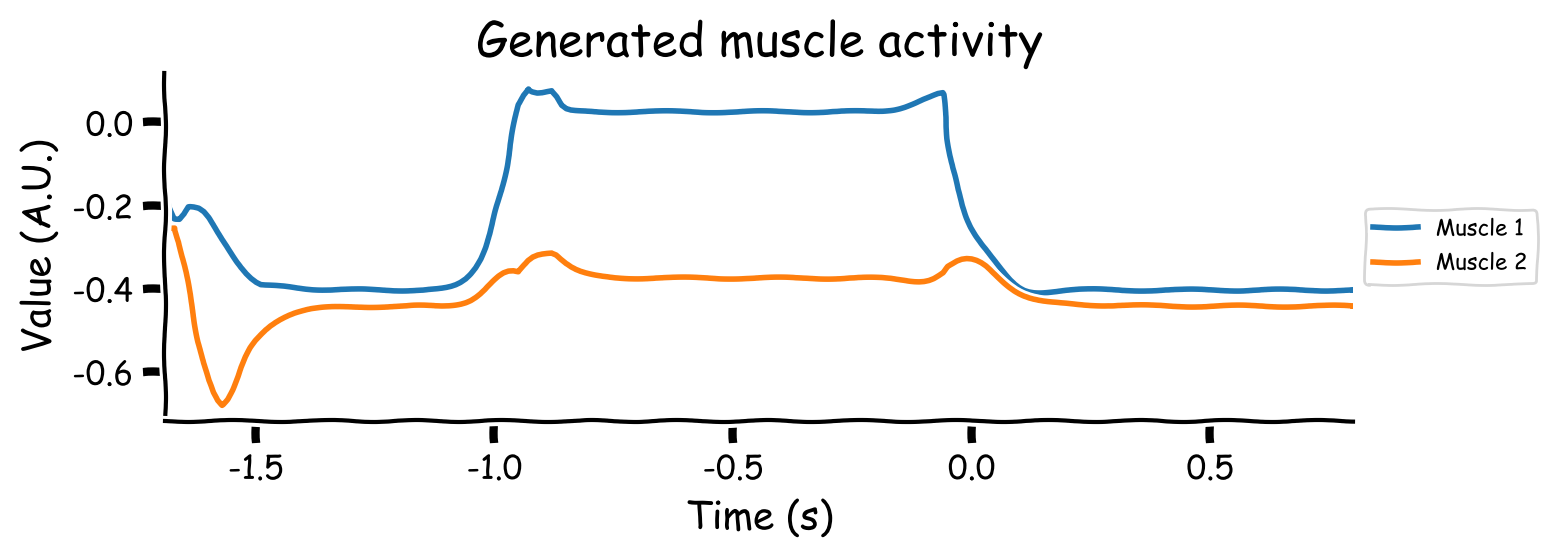

In [18]:
trajectory, hidden_states = generate_trajectory(model,
                                             inputs[0].unsqueeze(0),
                                             device)

with plt.xkcd():
  plot_hidden_unit_activations(hidden_states=hidden_states.squeeze().detach().cpu().numpy(),
                               times=times,
                               neurons_to_plot=7,
                               title='Hidden units')
  plot_muscles_over_time(times, trajectory.squeeze().detach().cpu().numpy(), 'Generated muscle activity')

Our untrained model generates funky oscillatory activity, but we'll fix that in training!

In [19]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_eval_model_Exercise")

## Activity 2.1: Evaluating the model

Now that we've built up our codebase, we're ready to train our model. This involves:

* Loading the data
* Instantiating the model
* Building a training loop
* Using stochastic gradient to train the model

To save you time, however, we've trained the model in advance. You'll thus load a trained checkpoint. This trained model can generate the right muscle outputs in response to the right inputs. Let's do a quick sanity check to make sure this is the case.

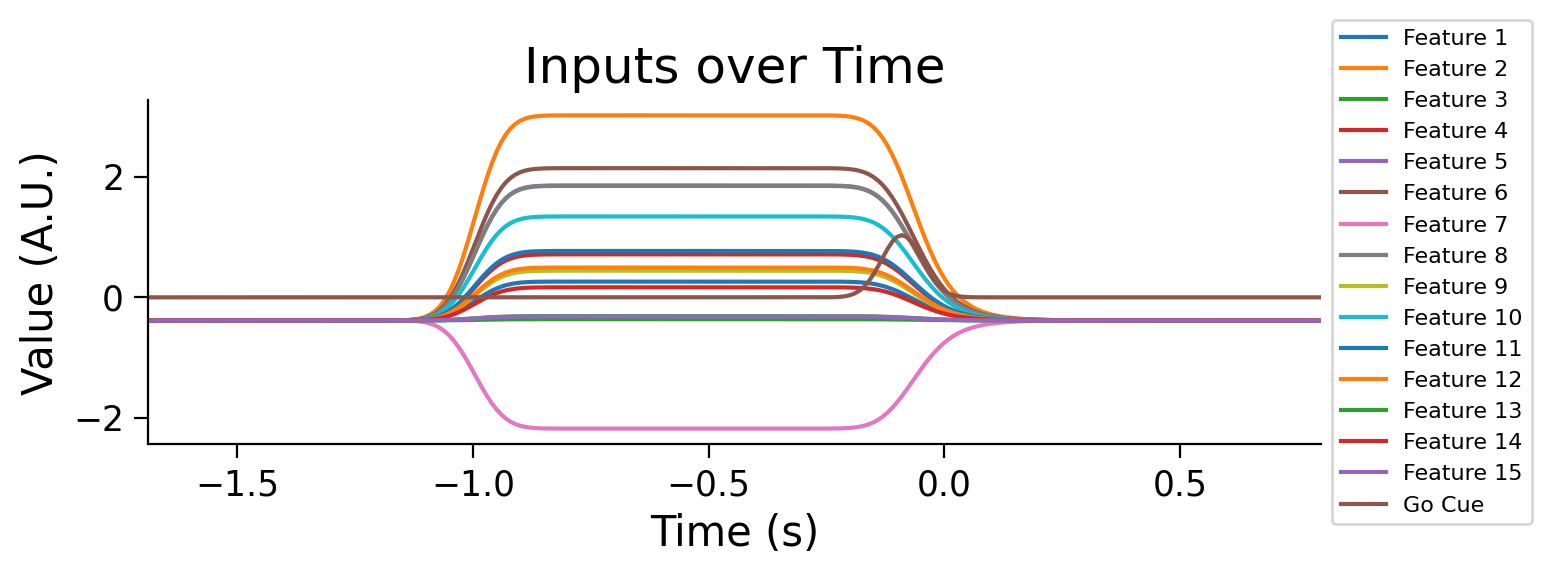

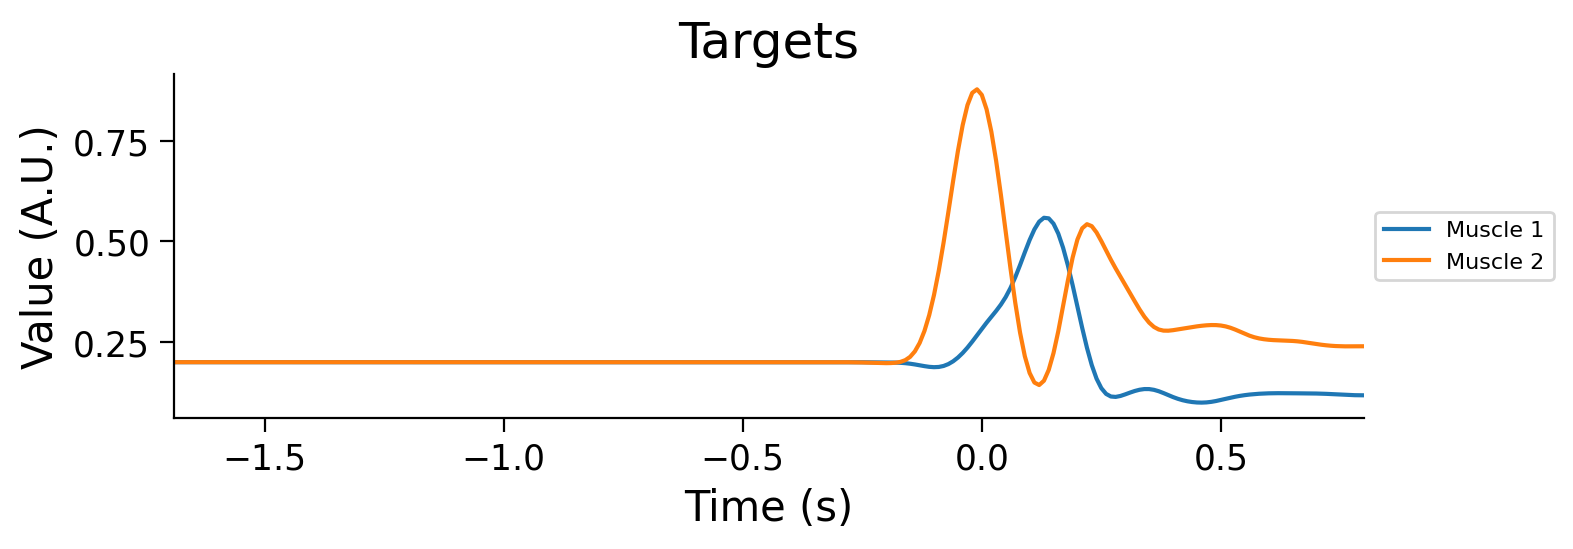

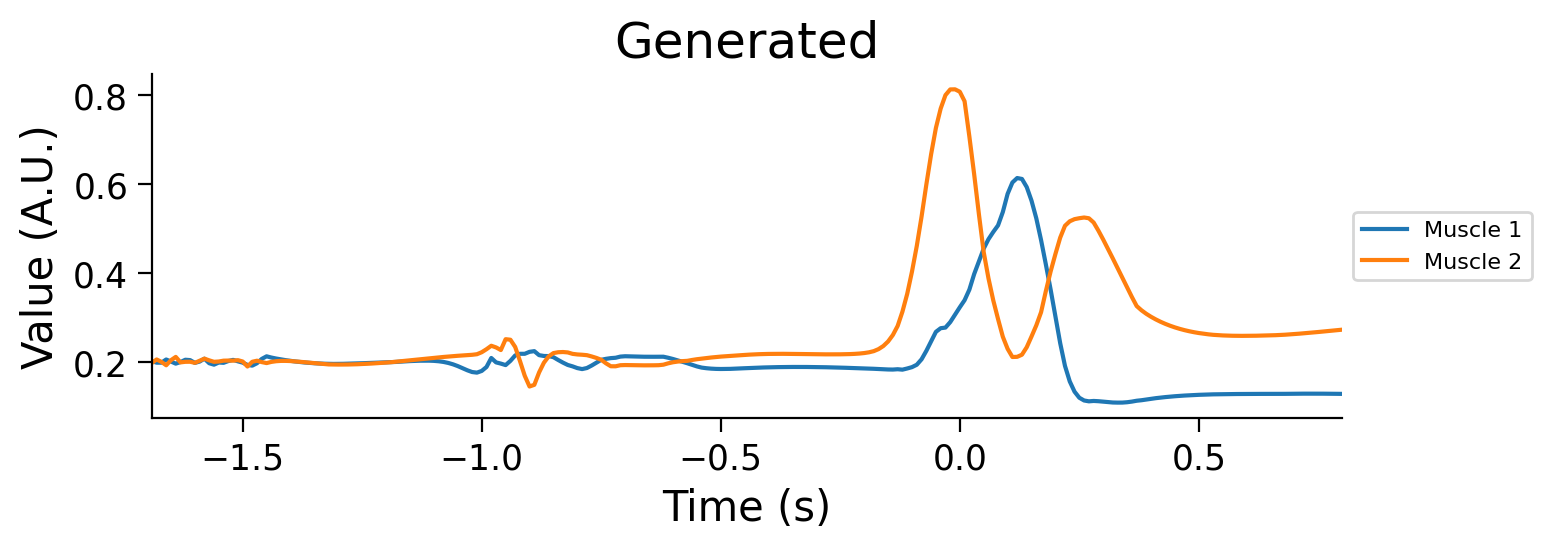

In [20]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
input_size = 16
hidden_size = 150
output_size = 2  # Number of muscles
g = 4  # g value
h_val = 1.0  # h value

unregularized_model = UnregularizedRNN(input_size, hidden_size, output_size, g, h_val)
unregularized_model.to(device)  # Move model to the appropriate device

# Load the pretrained model
model_path = 'unregularized_model_final.pth'
model_state_dict = torch.load(model_path, map_location=device)
unregularized_model.load_state_dict(model_state_dict)
unregularized_model.eval()  # Set model to evaluation mode

# Example index
idx = 0

# Ensure data is on the correct device
sample_input = normalised_inputs[train_idx[idx], ...].to(device)
sample_target = outputs[train_idx[idx], ...].to(device)

# Generate trajectory
generated_target, hidden_states = generate_trajectory(unregularized_model, sample_input.unsqueeze(0), device)

# Plotting
plot_inputs_over_time(times, sample_input.cpu())
plot_muscles_over_time(times, sample_target.cpu(), 'Targets')
plot_muscles_over_time(times, generated_target.squeeze().detach().cpu().numpy(), 'Generated')

Looks good! Our trained RNN is able to generate muscle activity similar to the measured activity.

## Activity 2.2: Comparing trained RNN with the brain

Our trained RNN transforms inputs into muscle activations. In effect, the RNN is a stand-in for motor cortex. The activity of the hidden units of the RNN should thus *look* like motor cortex. We thus plot different PSTHs of real neurons when they perform an animal performs a specific arm movement. Then, we plot different “PSTHs” of hidden units of the unregularized RNN.

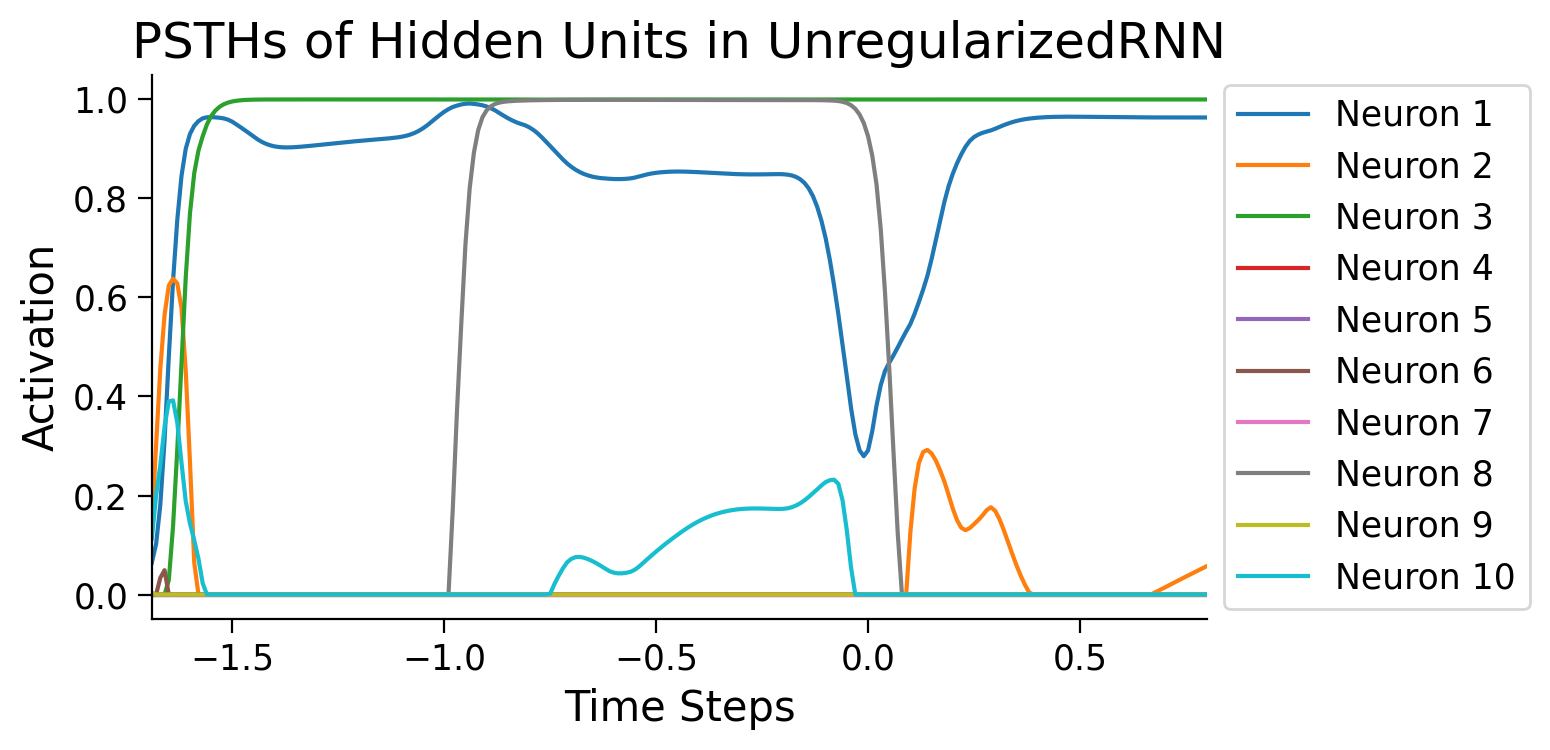

In [21]:
plot_hidden_unit_activations(hidden_states=hidden_states.squeeze().detach().cpu().numpy(),
                             times=times,
                             neurons_to_plot=10,
                             title='PSTHs of Hidden Units in UnregularizedRNN')

Let's do the same, now with real neural data. We load smoothed spiking data from Susillo et al. (2015). These are PSTHs of monkeys performing the same kind of reaching movement that the artificial neural network is trained on.

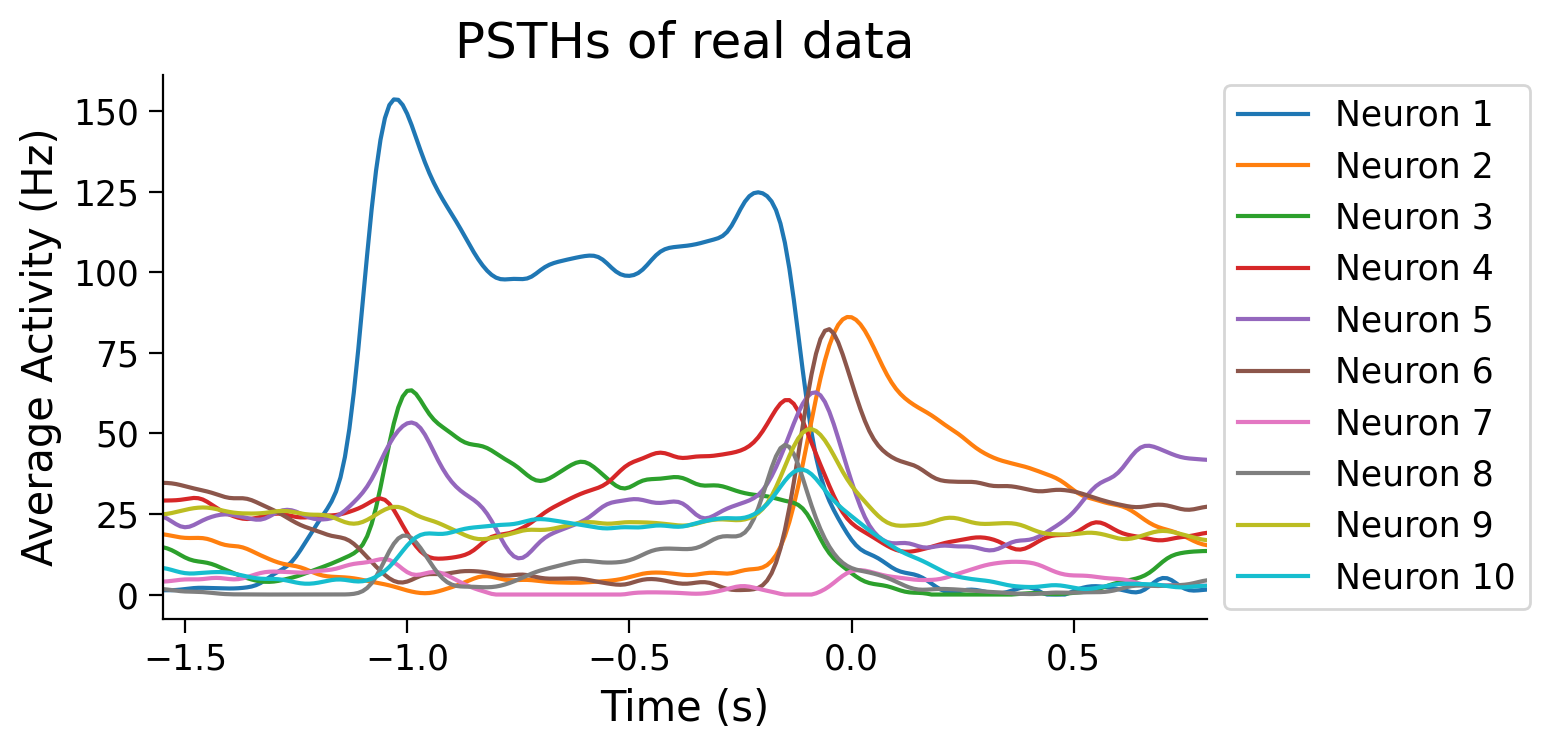

In [22]:
data = scipy.io.loadmat('m1_reaching_data.mat')
plot_psth(data, neurons_to_plot=10)

Qualitatively, that doesn't look like much of a match. **A trained RNN that performs the same task as the brain can have a very different latent representation**. In later tutorials, we'll cover in detail quantitative methods for evaluating how well representations in artificial and biological neural networks match each other. For now, let's try to get a qualitative match with better regularization.

# Section 3: Training a regularized task-driven neural network

The previous network found complicated solutions to the problem of generating muscle activity: the hidden activity of the network wasn't matched to what we see in real neurons. We'd like to obtain more **naturalistic solutions** that better match the brain by regularizing this network. Later, we'll test this regularized network for robustness and generalization to see if this also affects the network's ability to extrapolate beyond its training data.

Susillo et al. propose to regularize the network in many different ways.

#### Weight regularization

Synapses are expensive to grow and maintain. The authors thus propose to use a standard L2 penalty on the sum of squares of the weights:

$$R_0 = \sum_{ij} B_{ij}^2 + W_{ij}^2$$

Recall that $W$ are the weights that map the latent activity to the EMG data, while $B$ are the weights from the feedforward drive of the system. The penalty limits the size of the weights, potentially leading to more biologically plausible solutions

#### Firing rate regularization

Neural activity in biological neural networks is expensive. Thus, we add a penalty for the magnitude of the hidden activity in the network.

$$R_1 = \frac{1}{NT} \sum_{it} r_{it} ^ 2$$

Here $N$ is the number of hidden neurons and $T$ is the total number of discrete time steps in the simulation, and $r{it}$ is the activity of the hidden neurons over time.

#### Multiple delays

Neural activity should be robust to the exact delays between the preparatory input and the go cue. We augment the dataset with multiple delays between the signal and the go cue.

#### Less chaotic initialization regime

We initialized the previous RNN with large weights, putting the network in a chaotic regime, with high sensitivity to changes in activity. We'll dial down the initialization range in this network to obtain  dynamics at the edge of chaos. In practice, this involves changing the parameter that controls the magnitude of the initial recurrent weights $g$ from 4 to 1.5.

With all these changes implemented, we're ready to implement the regularized model.

In [23]:
class RegularizedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau_over_dt=5):
        super(RegularizedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau_over_dt = tau_over_dt  # Time constant
        self.output_linear = nn.Linear(hidden_size, output_size)

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float))))
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh

    def forward(self, input, hidden):
        # Calculate the visible firing rate from the hidden state.
        firing_rate_before = self.nonlinearity(hidden)

        # Update hidden state
        recurrent_drive = torch.matmul(self.J, firing_rate_before.transpose(0, 1))
        input_drive = torch.matmul(self.B, input.transpose(0, 1))
        total_drive = recurrent_drive + input_drive + self.bx.unsqueeze(1)
        total_drive = total_drive.transpose(0, 1)

        # Euler integration for continuous-time update
        hidden = hidden + (1 / self.tau_over_dt) * (-hidden + total_drive)

        # Calculate the new firing rate given the update.
        firing_rate = self.nonlinearity(hidden)

        # Project the firing rate linearly to form the output
        output = self.output_linear(firing_rate)

        # Regularization terms
        firing_rate_reg = firing_rate.pow(2).sum()

        return output, hidden, firing_rate_reg

    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

We split the dataset into training and validation sets. Importantly, we keep the different delays corresponding to the same condition in the same set.

In [24]:
train_flattened_inputs = normalised_inputs_with_delay[train_idx].view(-1, *normalised_inputs_with_delay.shape[2:])
train_flattened_targets = outputs_with_delay[train_idx].view(-1, *outputs_with_delay.shape[2:])

val_flattened_inputs = normalised_inputs_with_delay[val_idx].view(-1, *normalised_inputs_with_delay.shape[2:])
val_flattened_targets = outputs_with_delay[val_idx].view(-1, *outputs_with_delay.shape[2:])

# Create the dataset with the fixed delay
train_dataset = TimeseriesDataset(train_flattened_inputs, train_flattened_targets)
val_dataset = TimeseriesDataset(val_flattened_inputs, val_flattened_targets)

# Create DataLoaders
batch_size = 20
regularized_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
regularized_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Activity 3.1: Evaluating the model

Let's evaluate the model by looking at its generated activity! Once again, we skip the training of the model and load a model that has been trained previously, for convenience.

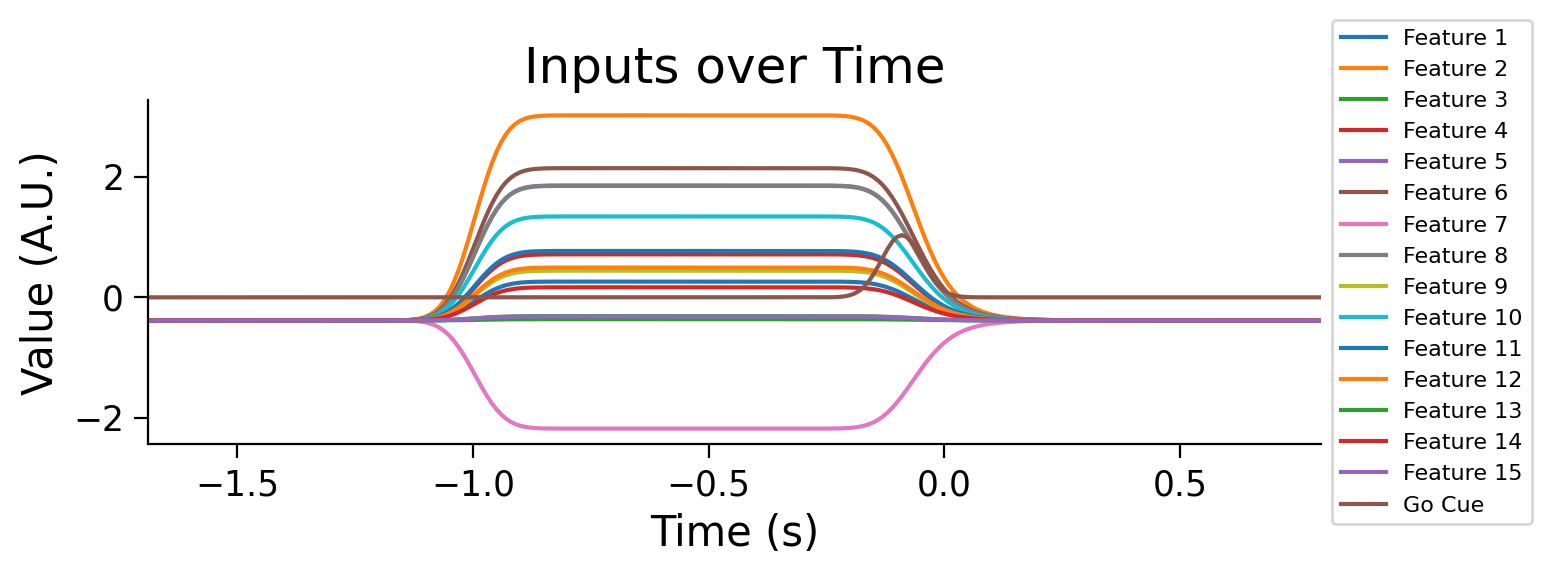

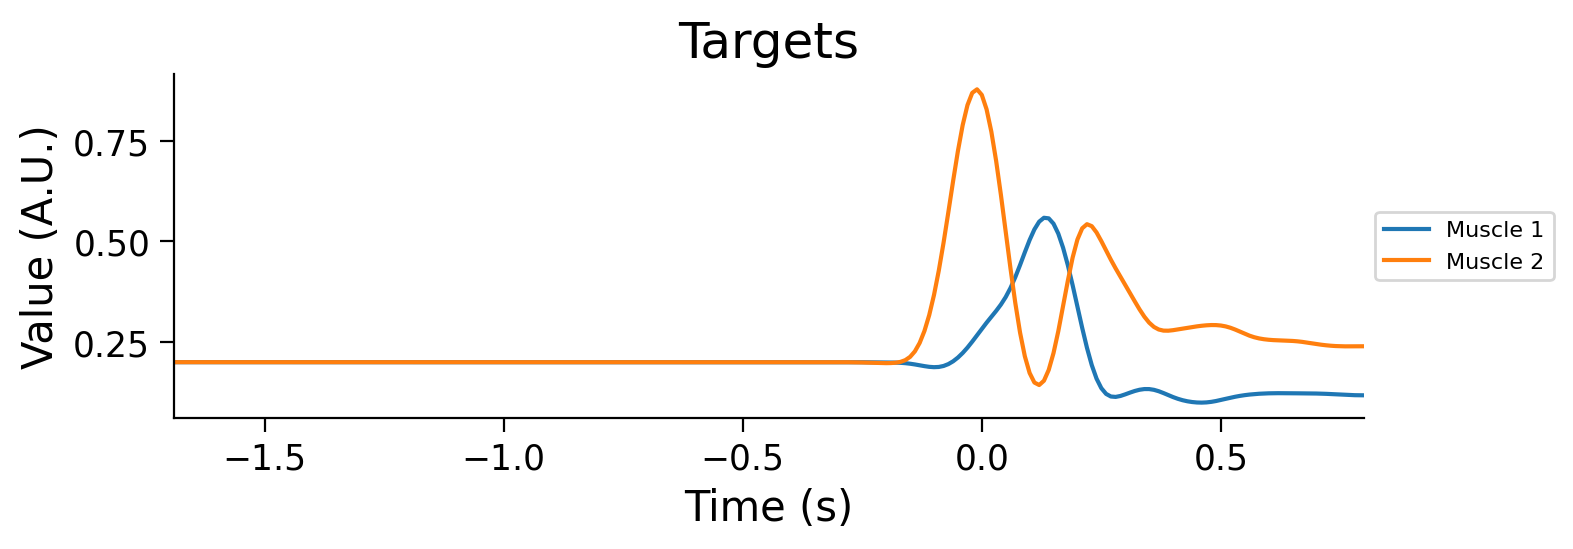

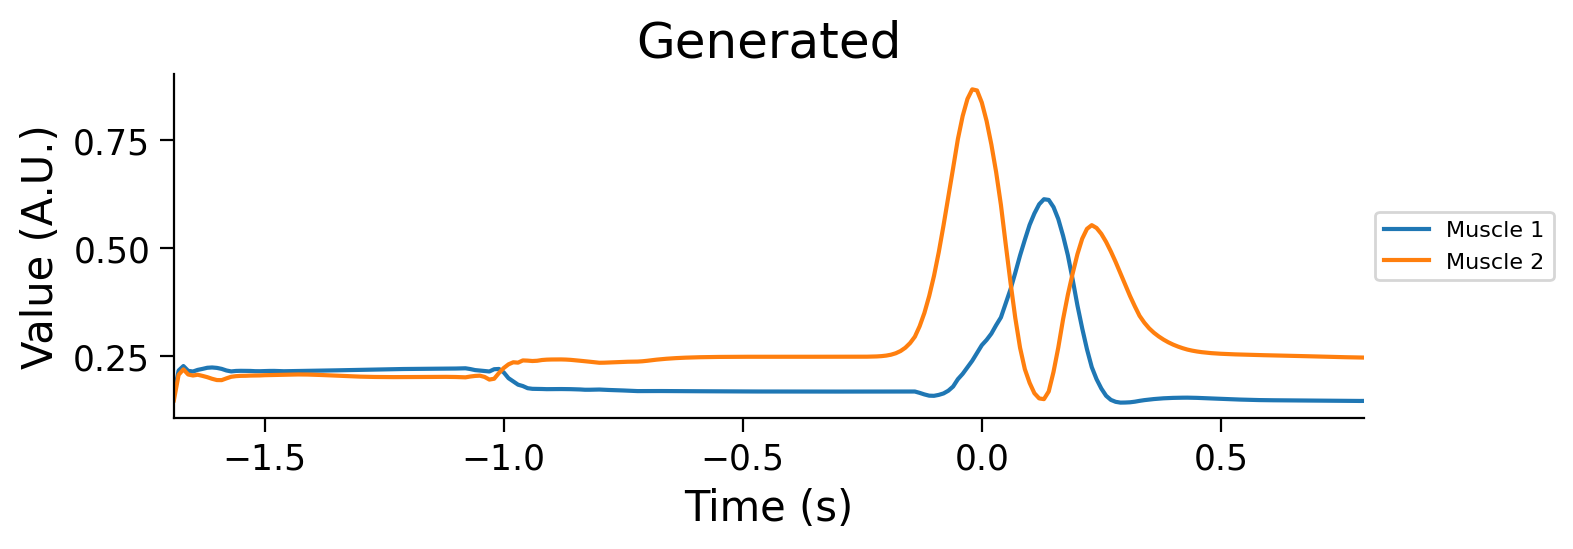

In [25]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
input_size = 16 # Features + Go Cue
hidden_size = 150
output_size = 2  # Number of muscles
g = 1.5  # g value
h_val = 1.0  # h value

regularized_model = RegularizedRNN(input_size, hidden_size, output_size, g, h_val)
regularized_model.to(device)  # Move model to the appropriate device

# Load the pretrained model
model_path = 'regularized_model_final.pth'
model_state_dict = torch.load(model_path, map_location=device)
regularized_model.load_state_dict(model_state_dict)
regularized_model.eval()  # Set model to evaluation mode

# Example index
idx = 0

# Ensure data is on the correct device
sample_input = normalised_inputs[train_idx[idx], ...].to(device)
sample_target = outputs[train_idx[idx], ...].to(device)

# Generate trajectory
generated_target, hidden_states = generate_trajectory(regularized_model, sample_input.unsqueeze(0), device)

# Plotting
plot_inputs_over_time(times, sample_input.cpu())
plot_muscles_over_time(times, sample_target.cpu(), 'Targets')
plot_muscles_over_time(times, generated_target.squeeze().detach().cpu().numpy(), 'Generated')

Looks promising–but how does the internal activity look?

In [26]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_ComplicatedRNN_Exercise")

## Activity 3.2: Comparing trained RNN with real data

Let's see if this regularized network's activity is aligned with the brain.

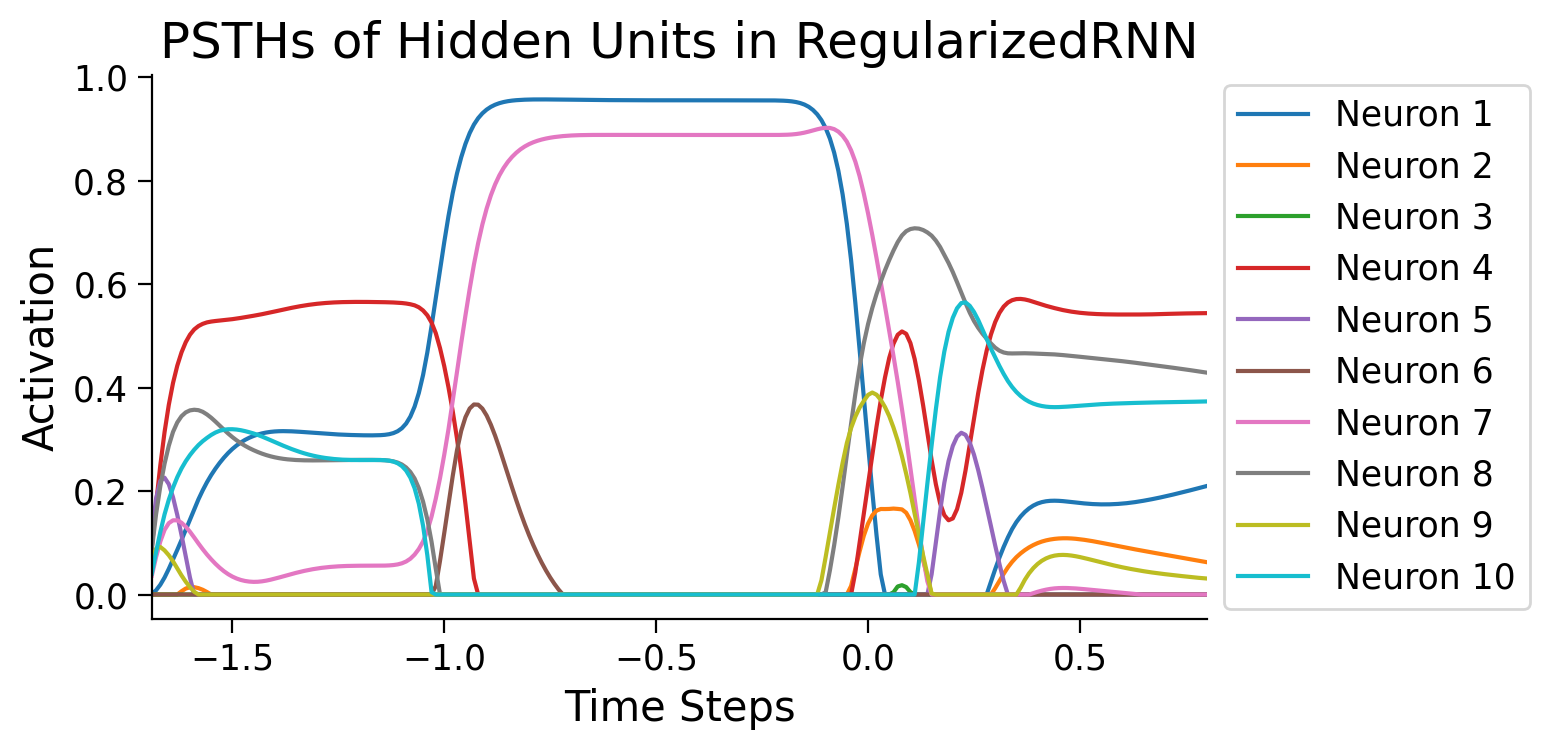

In [27]:
plot_hidden_unit_activations(hidden_states=hidden_states.squeeze().detach().cpu().numpy(),
                             times=times,
                             neurons_to_plot=10,
                             title='PSTHs of Hidden Units in RegularizedRNN')

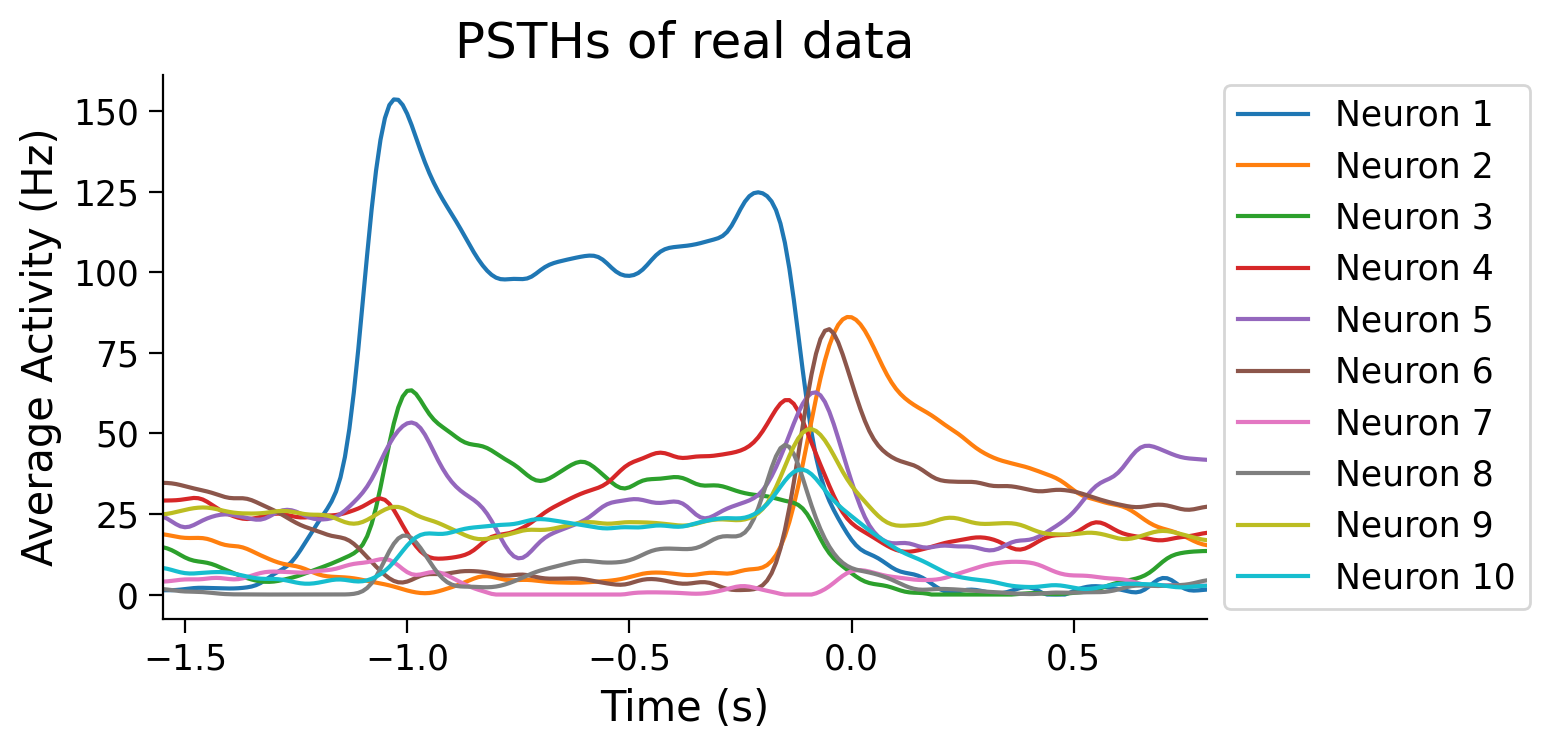

In [28]:
plot_psth(data, neurons_to_plot=10)

## Discussion point

Which one looks more like the brain?

In [29]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_Comparing_RRNs_Brain_Exercise")

# Section 4: Robustness to change in RNNs and the brain

In this section, we perturb our regularized and unregularized model's inputs and structural connectivity. Will regularization help the neural network be more resilient?

Let's start with perturbing the inputs. We use the smaller train dataset without the delay augmentations for this purpose.

In [30]:
test_dataset = TimeseriesDataset(normalised_inputs[train_idx], outputs[train_idx])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [31]:
def perturb_inputs(model, inputs, perturbation_strength):
    device = inputs.device
    # Perturb the inputs by adding random noise scaled by the perturbation strength and input strength
    input_strength = torch.norm(inputs, p=2, dim=-1, keepdim=True)  # Calculate the L2 norm of inputs
    noise = torch.rand(inputs.shape[0], 1, inputs.shape[2], device=device) * perturbation_strength * input_strength
    perturbed_inputs = inputs + noise
    return perturbed_inputs

def compute_loss(model, inputs, targets, criterion, device):
    batch_size = inputs.size(0)
    h = model.init_hidden(batch_size).to(device)  # Initialize hidden state
    losses = []
    for t in range(inputs.shape[1]):  # Iterate over time steps
        model_output = model(inputs[:, t, :], h)
        output, h, *rest = model_output[:2]
        loss = criterion(output, targets[:, t])  # Assume targets is a sequence of same length as inputs
        losses.append(loss)
    mean_loss = torch.mean(torch.stack(losses)).item()
    return mean_loss

def test_perturbed_inputs(model, perturbation_strengths, test_loader, criterion, device, max_error):
    model.eval()  # Set the model to evaluation mode
    perturbation_results = []

    for strength in perturbation_strengths:
        all_errors = []  # Store all errors for each perturbation strength to compute mean and s.d.
        print(f"Testing perturbation strength {strength}")
        for iteration in tqdm(range(30)):  # Repeat the procedure 30 times
            batch_errors = []  # Store errors for each batch

            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                # Compute error for original inputs
                # original_loss = compute_loss(model, inputs, targets, criterion, device)
                # Compute error for perturbed inputs

                perturbed_inputs = perturb_inputs(model, inputs, strength)
                perturbed_loss = compute_loss(model, perturbed_inputs, targets, criterion, device)

                # Store the normalized error.
                rel_error = perturbed_loss / max_error * 100
                batch_errors.append(rel_error)

            all_errors.extend(batch_errors)

        mean_error = np.mean(all_errors)
        std_error = np.std(all_errors)
        perturbation_results.append((mean_error, std_error))
        print(f"Completed testing for perturbation strength {strength}.")

    return perturbation_results

# Calculate the maximum error for a null model, the error when the output is constant.
max_error = ((outputs - outputs.mean(axis=[0, 1], keepdims=True)) ** 2).mean()

perturbation_strengths = [0.0125, 0.025, 0.05, 0.1, 0.2]
results_unregularized = test_perturbed_inputs(unregularized_model, perturbation_strengths, test_loader, nn.MSELoss(), device, max_error)
results_regularized = test_perturbed_inputs(regularized_model, perturbation_strengths, test_loader, nn.MSELoss(), device, max_error)

Testing perturbation strength 0.0125


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation strength 0.0125.
Testing perturbation strength 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation strength 0.025.
Testing perturbation strength 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation strength 0.05.
Testing perturbation strength 0.1


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation strength 0.1.
Testing perturbation strength 0.2


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation strength 0.2.
Testing perturbation strength 0.0125


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation strength 0.0125.
Testing perturbation strength 0.025


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation strength 0.025.
Testing perturbation strength 0.05


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation strength 0.05.
Testing perturbation strength 0.1


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation strength 0.1.
Testing perturbation strength 0.2


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation strength 0.2.


mean_errors_regularized (18.132654, 19.125116, 22.344646, 38.640877, 98.1013)
mean_errors_unregularized (26.58777, 27.562996, 33.69071, 55.270615, 114.197014)


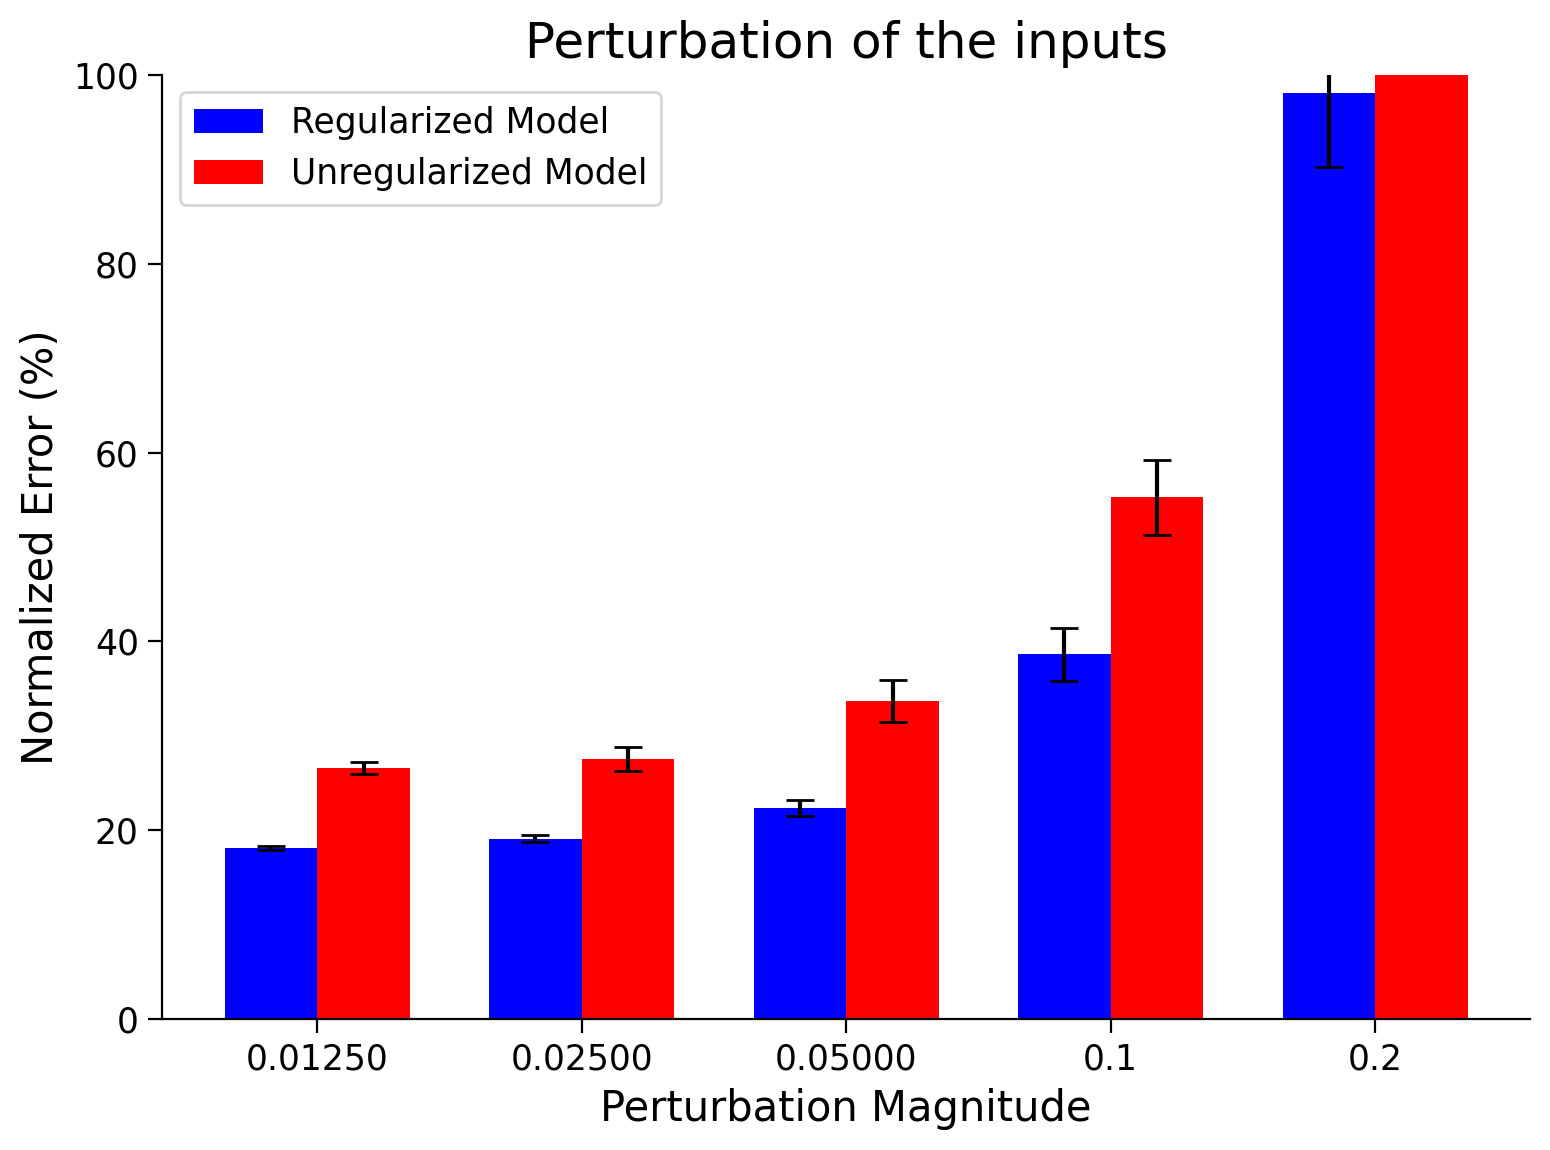

In [32]:
#Plot perturbation results
plot_perturbation_results(perturbation_strengths, results_regularized, results_unregularized, "Perturbation of the inputs")

Now, we proceed to do the same with the weights.

## Coding exercise 4.1: Weights perturbation

In [33]:
def calculate_mean_absolute_strength(model):
    # Calculate the mean absolute connection strength of the recurrent weight matrix
    return torch.mean(torch.abs(model.J)).item()

def perturb_recurrent_weights(model, mean_strength, perturbation_percentage):
    ###########################################################
    # Fill in the missing lines to complete the exercise
    raise NotImplementedError("Student exercise")
    ###########################################################
    perturbation_strength = ... * ...
    with torch.no_grad():
        noise = torch.randn_like(model.J) * perturbation_strength
        perturbed_weights = model.J + noise
        return perturbed_weights

def test_perturbed_structure(model, perturbation_percentages, test_loader, criterion, device, max_error):
    ###########################################################
    # Fill in the missing lines to complete the exercise
    raise NotImplementedError("Student exercise")
    ###########################################################
    model.eval()  # Set the model to evaluation mode
    mean_strength = calculate_mean_absolute_strength(model)
    perturbation_results = []  # List to store (mean error, std dev) tuples

    original_weights = model.J.data.clone()  # Save the original weights

    for percentage in ...:
        multiple_perturbations_error = []
        print(f"Testing perturbation percentage {percentage:.4f}")

        for perturbation in tqdm(range(30)):  # Perturb 30 times for each strength
            batch_errors = []
            perturbed_weights = perturb_recurrent_weights(model, mean_strength, percentage)
            model.J.data = perturbed_weights.data

            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                batch_size = inputs.size(0)
                h = model.init_hidden(batch_size).to(device)

                outputs = torch.zeros_like(targets).to(device)
                for t in range(inputs.shape[1]):
                    output, h, *rest = ...
                    outputs[:, t, :] = output

                loss = criterion(outputs, targets).item()
                batch_errors.append(loss)

            # Reset to original weights after each perturbation
            model.J.data = original_weights.data
            multiple_perturbations_error.append(np.mean(batch_errors))

        mean_error = np.mean(multiple_perturbations_error)  # Average over the 50 perturbations
        std_dev_error = np.std(multiple_perturbations_error)  # Standard deviation for error bars
        perturbation_results.append((100 * mean_error / max_error, 100 * std_dev_error / max_error))

        # Normalize the errors
        print(f"Completed testing for perturbation percentage {percentage:.4f}. Mean error: {mean_error:.4f}, Std. dev.: {std_dev_error:.4f}\n")

    return perturbation_results

In [34]:
# to_remove solution

def calculate_mean_absolute_strength(model):
    # Calculate the mean absolute connection strength of the recurrent weight matrix
    return torch.mean(torch.abs(model.J)).item()

def perturb_recurrent_weights(model, mean_strength, perturbation_percentage):
    perturbation_strength = mean_strength * perturbation_percentage
    with torch.no_grad():
        noise = torch.randn_like(model.J) * perturbation_strength
        perturbed_weights = model.J + noise
        return perturbed_weights

def test_perturbed_structure(model, perturbation_percentages, test_loader, criterion, device, max_error):
    model.eval()  # Set the model to evaluation mode
    mean_strength = calculate_mean_absolute_strength(model)
    perturbation_results = []  # List to store (mean error, std dev) tuples

    original_weights = model.J.data.clone()  # Save the original weights

    for percentage in perturbation_percentages:
        multiple_perturbations_error = []
        print(f"Testing perturbation percentage {percentage:.4f}")

        for perturbation in tqdm(range(30)):  # Perturb 30 times for each strength
            batch_errors = []
            perturbed_weights = perturb_recurrent_weights(model, mean_strength, percentage)
            model.J.data = perturbed_weights.data

            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                batch_size = inputs.size(0)
                h = model.init_hidden(batch_size).to(device)

                outputs = torch.zeros_like(targets).to(device)
                for t in range(inputs.shape[1]):
                    output, h, *rest = model(inputs[:, t, :], h)
                    outputs[:, t, :] = output

                loss = criterion(outputs, targets).item()
                batch_errors.append(loss)

            # Reset to original weights after each perturbation
            model.J.data = original_weights.data
            multiple_perturbations_error.append(np.mean(batch_errors))

        mean_error = np.mean(multiple_perturbations_error)  # Average over the 50 perturbations
        std_dev_error = np.std(multiple_perturbations_error)  # Standard deviation for error bars
        perturbation_results.append((100 * mean_error / max_error, 100 * std_dev_error / max_error))

        # Normalize the errors
        print(f"Completed testing for perturbation percentage {percentage:.4f}. Mean error: {mean_error:.4f}, Std. dev.: {std_dev_error:.4f}\n")

    return perturbation_results

In [35]:
# Calculate the maximum error for a null model, the error when the output is constant.
max_error = ((outputs - outputs.mean(axis=[0, 1], keepdims=True)) ** 2).mean()

# Define perturbation strengths as percentages
perturbation_strengths = [0.01, .1, .2, .4, .8]

# Function calls for regularized and unregularized models
results_regularized_weights = test_perturbed_structure(regularized_model, perturbation_strengths, test_loader, nn.MSELoss(), device, max_error)
results_unregularized_weights = test_perturbed_structure(unregularized_model, perturbation_strengths, test_loader, nn.MSELoss(), device, max_error)

Testing perturbation percentage 0.0100


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation percentage 0.0100. Mean error: 0.0045, Std. dev.: 0.0000

Testing perturbation percentage 0.1000


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation percentage 0.1000. Mean error: 0.0046, Std. dev.: 0.0001

Testing perturbation percentage 0.2000


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation percentage 0.2000. Mean error: 0.0051, Std. dev.: 0.0004

Testing perturbation percentage 0.4000


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation percentage 0.4000. Mean error: 0.0075, Std. dev.: 0.0018

Testing perturbation percentage 0.8000


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation percentage 0.8000. Mean error: 0.0157, Std. dev.: 0.0040

Testing perturbation percentage 0.0100


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation percentage 0.0100. Mean error: 0.0068, Std. dev.: 0.0002

Testing perturbation percentage 0.1000


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation percentage 0.1000. Mean error: 0.0148, Std. dev.: 0.0047

Testing perturbation percentage 0.2000


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation percentage 0.2000. Mean error: 0.0310, Std. dev.: 0.0133

Testing perturbation percentage 0.4000


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation percentage 0.4000. Mean error: 0.0520, Std. dev.: 0.0223

Testing perturbation percentage 0.8000


  0%|          | 0/30 [00:00<?, ?it/s]

Completed testing for perturbation percentage 0.8000. Mean error: 0.0642, Std. dev.: 0.0205



mean_errors_regularized (tensor(17.7874), tensor(18.3424), tensor(20.0408), tensor(29.8501), tensor(62.1556))
mean_errors_unregularized (tensor(26.8625), tensor(58.6465), tensor(122.7061), tensor(206.1021), tensor(254.1142))


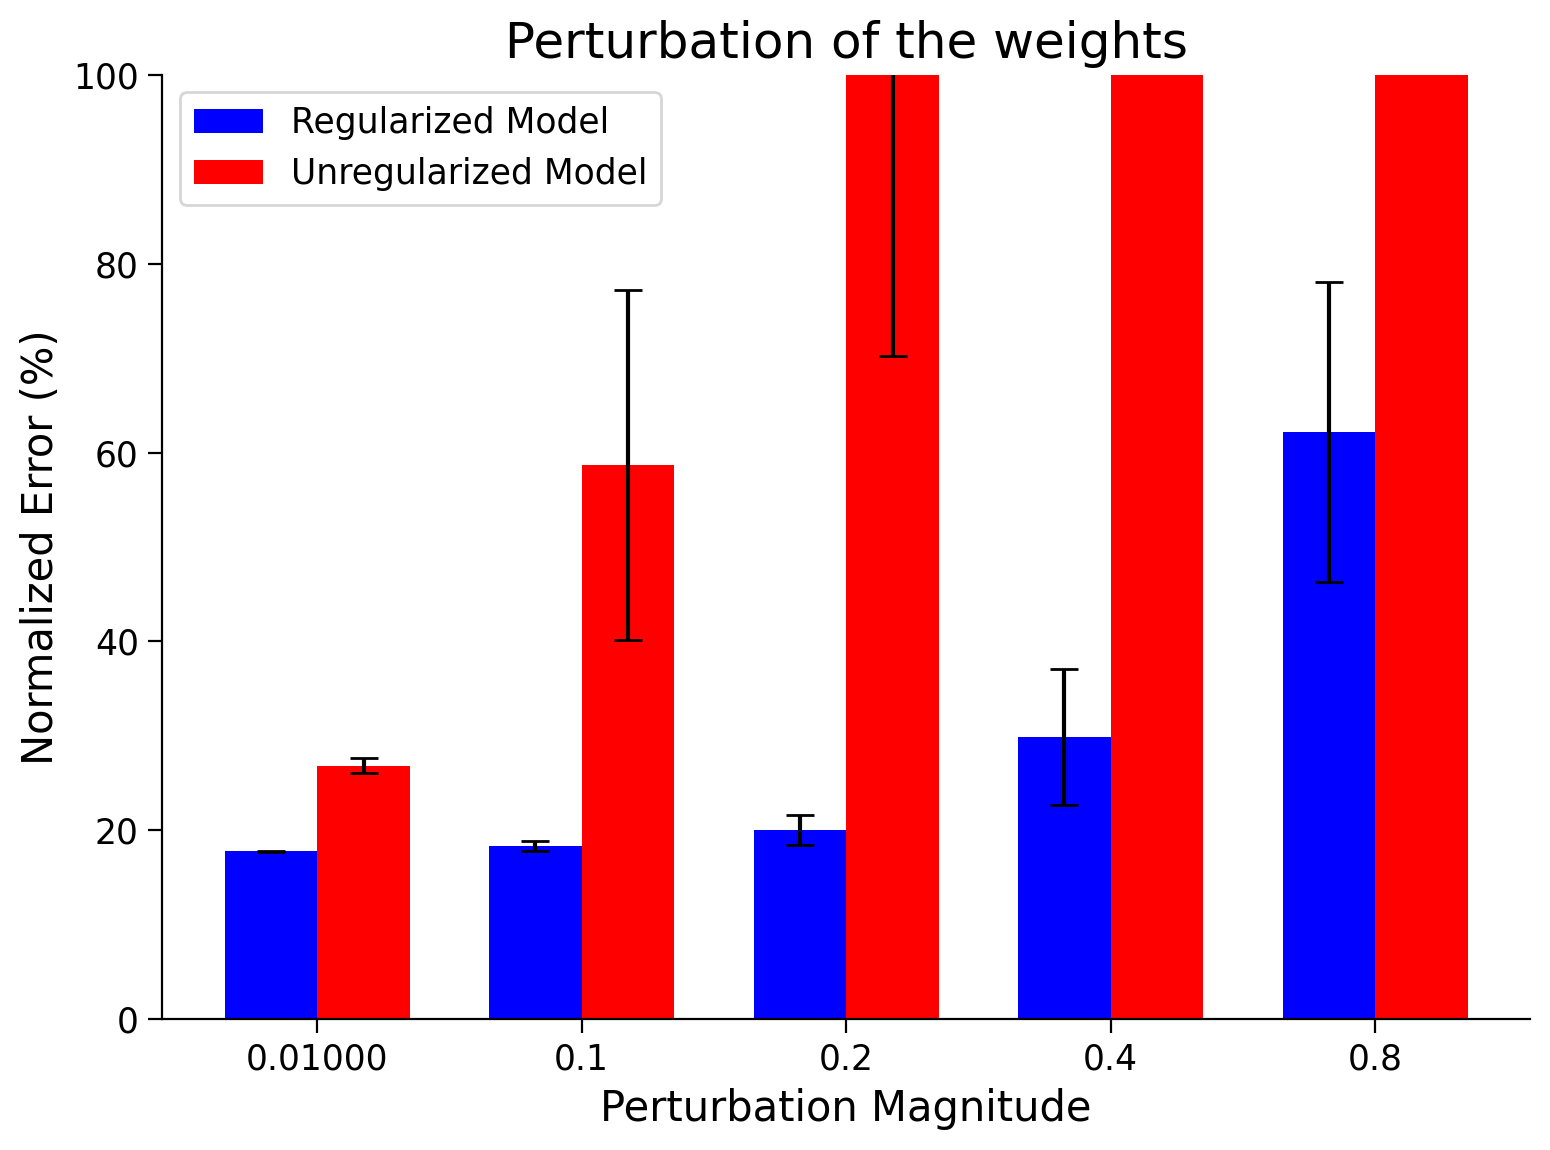

In [36]:
# Plot perturbation results
plot_perturbation_results(perturbation_strengths, results_regularized_weights, results_unregularized_weights, "Perturbation of the weights")

In [37]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_Weights_Perturbation_Exercise")

## Discussion point 1

Why is the regularized RNN more resistant to noise?

In [38]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_Robustness_Exercise")

## Discussion point 2

Is the regularized RNN “how the brain works” in motor cortex? If not, why is it useful to model this way? Does this experiment suggest that a system that can perform a task and generalize well is necessarily brain-like? If not, what else is required? Plasticity? Complex decision-making? Sensory integration? Agency? Autonomy?

In [39]:
# @title Submit your feedback
#content_review(f"{feedback_prefix}_Plausibility_Exercise")

# Summary

* Neuroscientists often aim to uncover *how* the brain performs a task
* Artificial neural networks are a useful tool to investigate how a computation might be performed
  * We often care about biological plausibility: the operations performed by the network should roughly match those that the brain can perform. For instance, while RNNs have been surpassed by transformers for natural language processing, they remain popular in neuroscience.
* Neuroscientists often care about whether a model generalizes across circumstances that an organism might face
  * We tested robustness to noise (e.g. neural noise) and robustness to weight changes (e.g. rollover in synapses) across different models and found regularized models offered a useful **inductive bias** which generalized better
* The tools to improve generalization in task-driven neural networks are similar to the ones used in AI more generally: regularization, augmentations, but also potentially pretraining and transfer learning
* Networks that perform similar tasks to the brain and generalize well *sometimes* converge to similar solutions to the brain. We don't fully understand this phenomenon, and we'll introduce tools throughout the course to more quantitatively assess the correspondence.